In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import anndata as ad
import os

sc.settings.verbosity = 3

## Filter and combine

In [2]:
data_dir = "./data/raw/"
h5_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".h5")]
len(h5_files)

13

In [ ]:
for ix, h5_file in enumerate(h5_files):
    print(f"Processing file {ix + 1}/{len(h5_files)}: {h5_file}")

    adata = sc.read_10x_h5(h5_file)

    adata.var_names_make_unique()

    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_cells(adata, max_genes=7000)
    sc.pp.filter_genes(adata, min_cells=3)

    # individual scrublet score
    # https://discourse.scverse.org/t/how-to-concatenate-anndata-properly/887
    sc.pp.scrublet(adata)

    # store the filtered data
    filtered_dir = "./data/filtered/"

    # maybe perform Mt25 removal here
    
    # write as h5ad with basename
    basename = os.path.basename(h5_file)
    basename = os.path.splitext(basename)[0]
    filtered_file = os.path.join(filtered_dir, f"{basename}_filtered.h5ad")
    adata.write_h5ad(filtered_file)


In [4]:
filtered_data_dir = "./data/filtered"
filtered_h5_files = [os.path.join(filtered_data_dir, f) for f in os.listdir(filtered_data_dir) if f.endswith(".h5ad")]

In [ ]:
adatas = []
for ix, filtered_h5_file in enumerate(filtered_h5_files):
    adata = sc.read_h5ad(filtered_h5_file)
    adatas.append(adata)

adata = ad.concat(adatas, join="outer")

# write as h5ad
combined_file = os.path.join(filtered_data_dir, "combined_filtered.h5ad")
adata.write_h5ad(combined_file)

## Clean

In [2]:
adata = sc.read_h5ad('/home/enno/code/scAnalysis/data/merged/combined_filtered.h5ad')
adata.obs_names_make_unique()

/home/enno/anaconda3/envs/kameneva/lib/python3.9/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [3]:
adata.shape

(157586, 26116)

In [4]:
# mito
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True)

In [ ]:
# remove more than 25% mitochondrial genes
adata = adata[adata.obs.pct_counts_mt < 25, :]
adata.shape

(146273, 26116)

: 

In [ ]:
# identify HVGs and subset
# https://discourse.scverse.org/t/how-to-handle-data-lognormalization-when-using-highly-variable-genes-with-flavor-seurat-v3/1076
sc.pp.highly_variable_genes(adata, n_top_genes=2000, inplace=True, flavor="seurat_v3", subset=True)

extracting highly variable genes


/home/enno/anaconda3/envs/kameneva/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:172: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}


In [ ]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

normalizing counts per cell


    finished (0:00:00)


In [ ]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:04:58)


In [10]:
# cell cycle regression
# https://github.com/scverse/scanpy_usage/blob/master/180209_cell_cycle/cell_cycle.ipynb

cell_cycle_genes = [x.strip() for x in open('./data/regev_lab_cell_cycle_genes.txt')]

s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]

sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)
sc.pp.regress_out(adata, ['S_score', 'G2M_score'])
sc.pp.scale(adata)

calculating cell cycle phase
computing score 'S_score'
       'PRIM1', 'MLF1IP', 'RFC2', 'RPA2', 'NASP', 'RAD51AP1', 'GMNN', 'WDR76',
       'SLBP', 'CCNE2', 'UBR7', 'POLD3', 'MSH2', 'RAD51', 'CDC45', 'CDC6',
       'EXO1', 'TIPIN', 'DSCC1', 'BLM', 'CASP8AP2', 'USP1', 'POLA1', 'CHAF1B',
       'BRIP1', 'E2F8'],
      dtype='object')
    finished: added
    'S_score', score of gene set (adata.obs).
    212 total control genes are used. (0:00:01)
computing score 'G2M_score'
       'HJURP', 'HN1', 'CDC25C', 'KIF2C', 'RANGAP1', 'NCAPD2', 'CDCA2', 'LBR',
       'CKAP5', 'CTCF', 'G2E3', 'GAS2L3', 'CBX5'],
      dtype='object')
    finished: added
    'G2M_score', score of gene set (adata.obs).
    501 total control genes are used. (0:00:01)
-->     'phase', cell cycle phase (adata.obs)
regressing out ['S_score', 'G2M_score']
    finished (0:03:37)


In [11]:
# store as h5ad
adata.write_h5ad('./data/merged/cleaned.h5ad')

## UMAP und Cluster

In [2]:
adata = sc.read_h5ad('data/merged/cleaned.h5ad')

In [6]:
sc.tl.pca(adata, n_comps=50)

computing PCA
    with n_comps=50
    finished (0:00:34)


In [4]:
sc.pp.neighbors(adata, n_neighbors=5, n_pcs=15)

computing neighbors
computing PCA
    with n_comps=15


/home/enno/anaconda3/envs/kameneva/lib/python3.9/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 1000 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


    finished (0:00:12)


/home/enno/anaconda3/envs/kameneva/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:46)


In [7]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:01:22)


<Axes: title={'center': 'phase'}, xlabel='PC1', ylabel='PC2'>

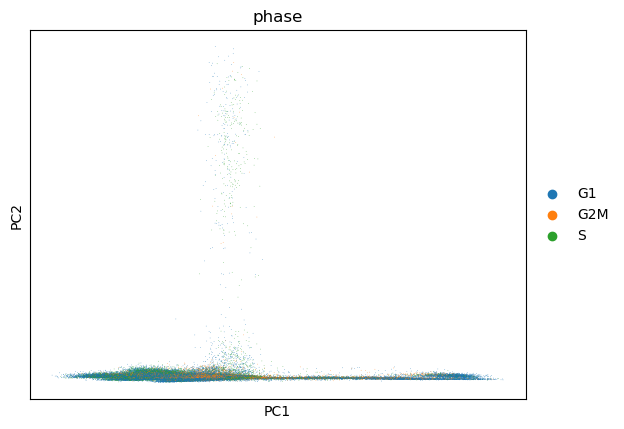

In [ ]:
# cell cycle phase
sc.pl.pca(adata, color='phase', use_raw=False, show=False)

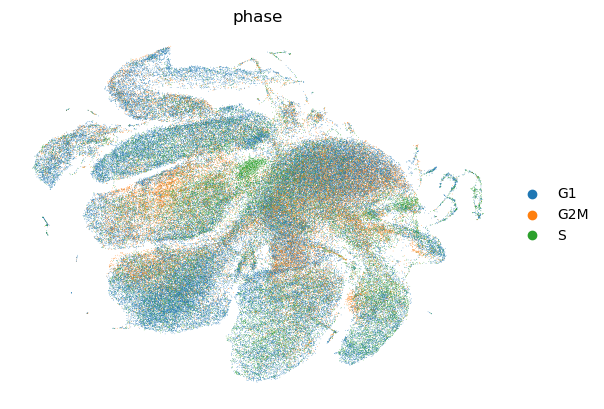

In [8]:
sc.pl.umap(adata, color='phase', use_raw=False, frameon=False)

In [40]:
# clustering
sc.tl.leiden(adata, resolution=0.3)

running Leiden clustering
    finished: found 28 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:24)


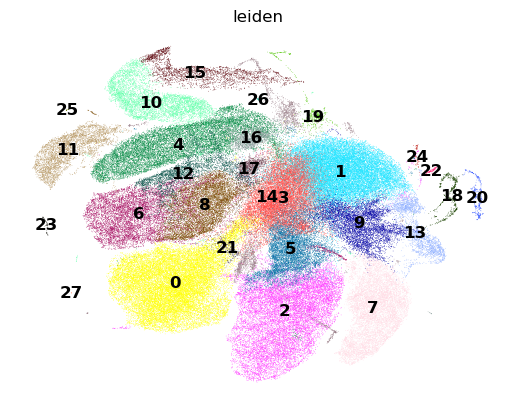

In [41]:
sc.pl.umap(adata, color='leiden', use_raw=False, frameon=False, legend_loc='on data', legend_fontsize=12)

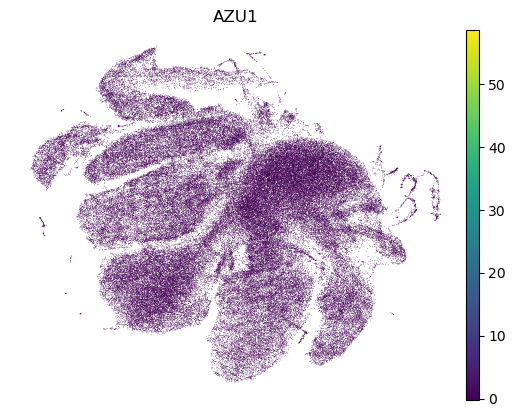

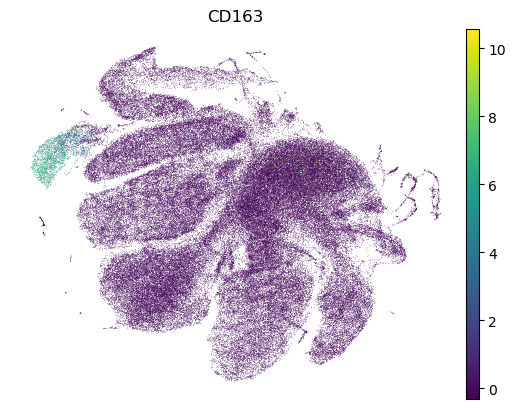

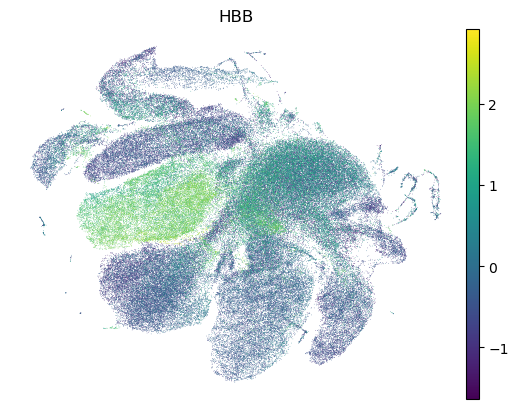

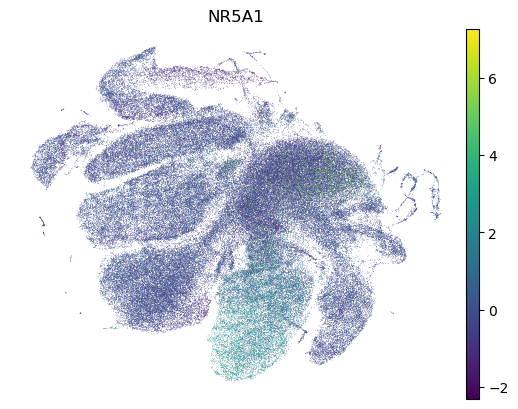

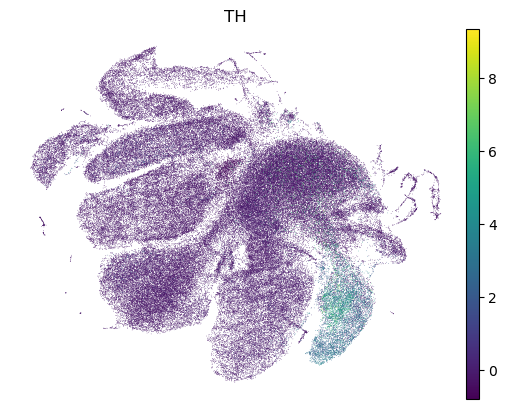

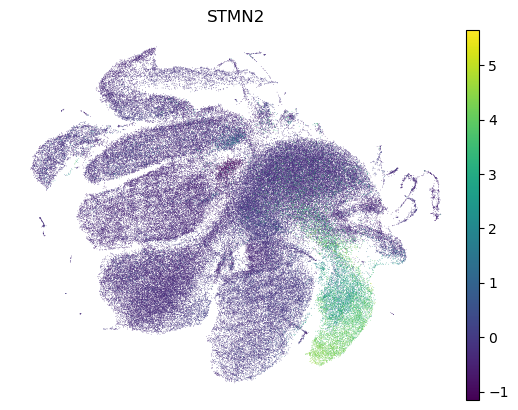

In [33]:
# UMAP with genes: PECAM1, KDR
# sc.pl.umap(adata, color=['PECAM1', 'KDR'], use_raw=False, frameon=False)

# UMAP with genes: PRRX1
# sc.pl.umap(adata, color=['PRRX1'], use_raw=False, frameon=False)

# UMAP with genes: GATA4, HAND2
# sc.pl.umap(adata, color=['GATA4', 'HAND2'], use_raw=False, frameon=False)

# UMAP with genes: HNF4A
# sc.pl.umap(adata, color=['HNF4A'], use_raw=False, frameon=False)

# UMAP with genes: SPINK2, AZU1
sc.pl.umap(adata, color=['AZU1'], use_raw=False, frameon=False)

# UMAP with genes: FCGR1A, CD163
sc.pl.umap(adata, color=['CD163'], use_raw=False, frameon=False)

# UMAP with genes: HBA2, HBB
sc.pl.umap(adata, color=['HBB'], use_raw=False, frameon=False)

# UMAP with genes: MITF
# sc.pl.umap(adata, color=['MITF'], use_raw=False, frameon=False)

# UMAP with genes: PAX2
# sc.pl.umap(adata, color=['PAX2'], use_raw=False, frameon=False)

# UMAP with genes: NR5A1
sc.pl.umap(adata, color=['NR5A1'], use_raw=False, frameon=False)

# UMAP with genes: SOX10, PLP1, FOXD3
# sc.pl.umap(adata, color=['SOX10', 'PLP1', 'FOXD3'], use_raw=False, frameon=False)

# UMAP with genes: ELAVL3, ELAVL4, PHOX2B, TH
sc.pl.umap(adata, color=['TH'], use_raw=False, frameon=False)

# UMAP with genes: STMN2
sc.pl.umap(adata, color=['STMN2'], use_raw=False, frameon=False)

In [ ]:
# top 5 differential expressed genes per cluster
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:03)


/home/enno/anaconda3/envs/kameneva/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/enno/anaconda3/envs/kameneva/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/enno/anaconda3/envs/kameneva/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/enno/anaconda3/envs/kameneva/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/enno/anaconda3/envs/kameneva/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`


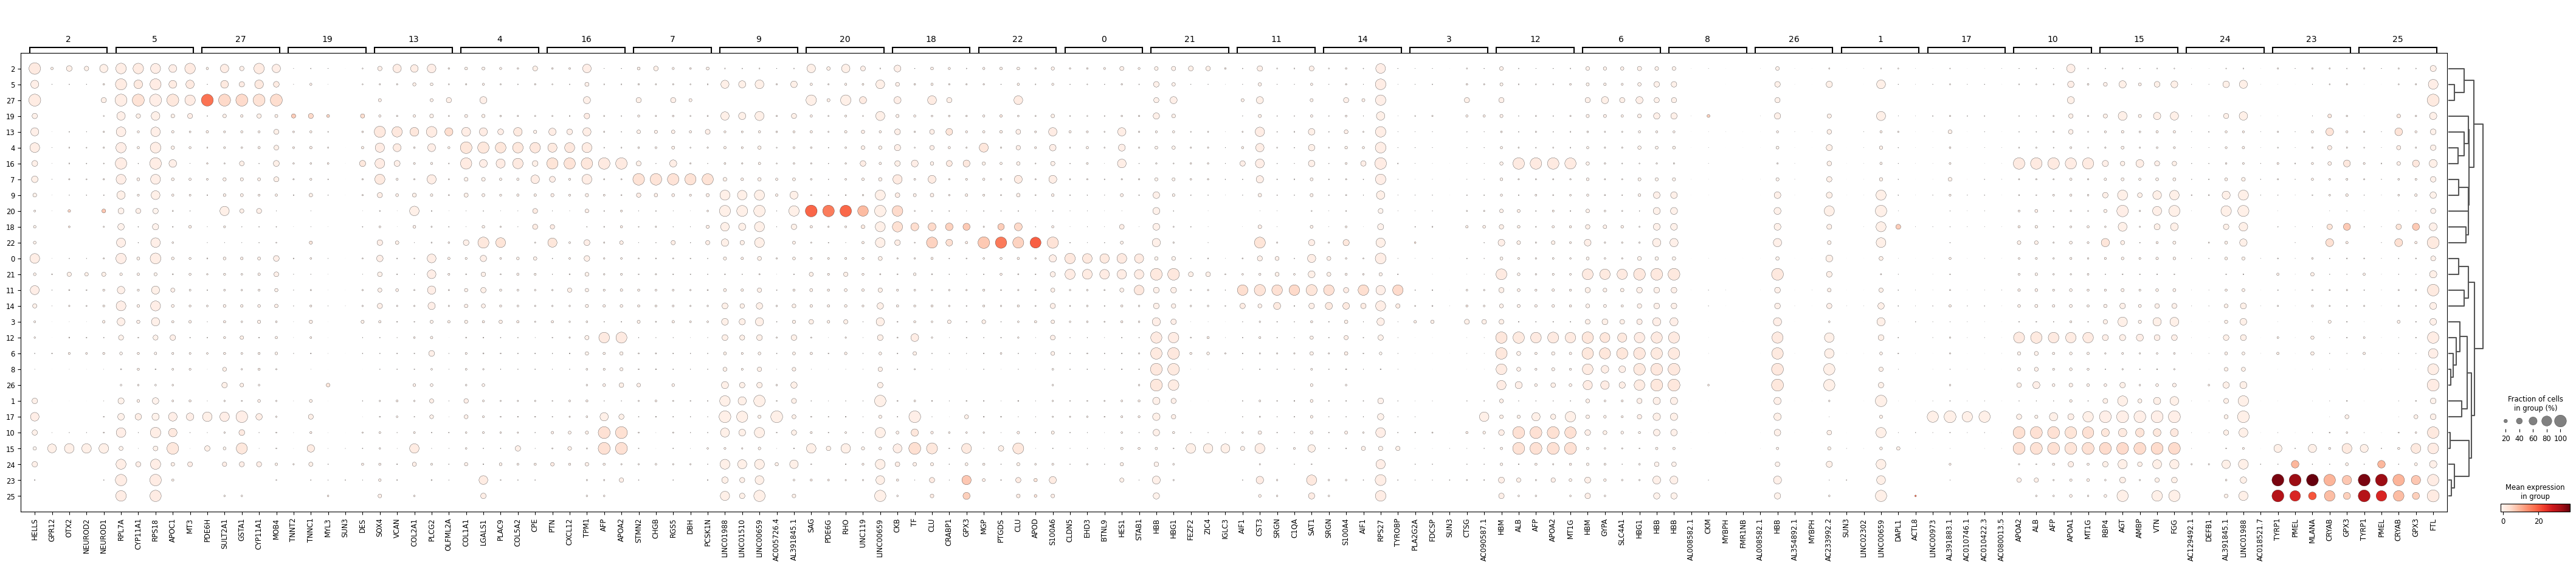

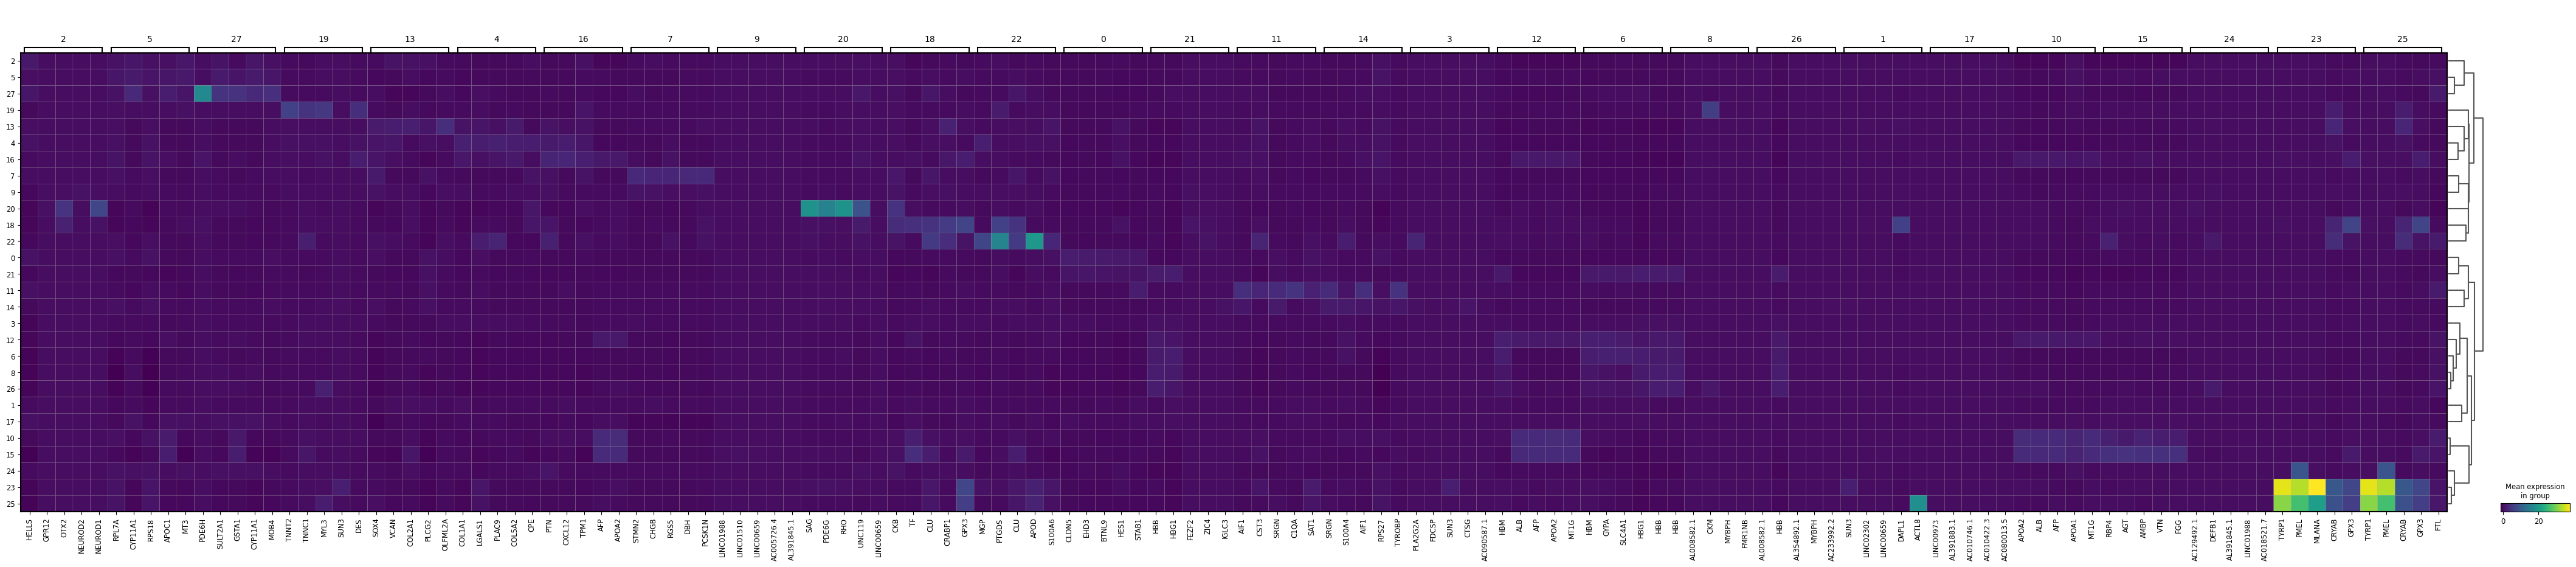

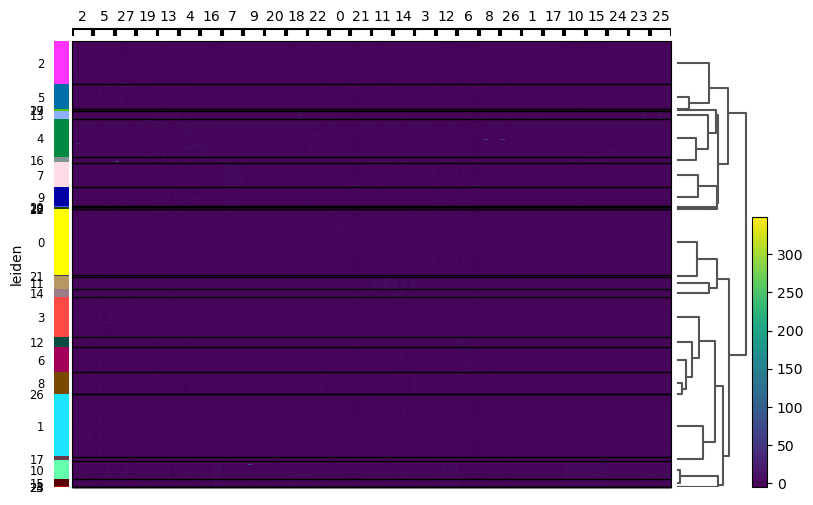

In [ ]:
sc.tl.dendrogram(adata, groupby='leiden')
sc.pl.rank_genes_groups_dotplot(adata, n_genes=5, use_raw=False)
sc.pl.rank_genes_groups_matrixplot(adata, n_genes=5, use_raw=False)
sc.pl.rank_genes_groups_heatmap(adata, n_genes=5, use_raw=False)